# BBB(Bayes by Backprop.) CNN MNIST Example

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### Data Loader

In [7]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    ])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

# choose the training and test datasets
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=test_transform)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64)

### Data Samples

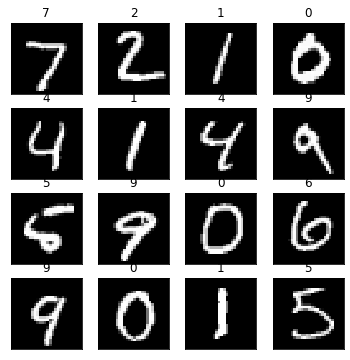

In [8]:
# Read from test loader
batch = next(iter(test_loader))
data, target = batch

# Convert tensor to numpy array
_data = data.data.cpu().numpy()
_target = target.data.cpu().numpy()

# Draw the samples
plt.figure(figsize=[6, 6])
for i in range(16):
    plt.subplot(4, 4, i+1)
    clazz = str(_target[i])
    plt.title(clazz)
    plt.imshow(_data[i][0], cmap='gist_gray')
    plt.xticks([])
    plt.yticks([])
plt.show()


### Model

In [75]:
class GaussianWeight(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.mu = nn.Parameter(torch.Tensor(*features).normal_(0, 1e-2))
        self.rho = nn.Parameter(torch.Tensor(*features).fill_(-5))
        
    @property
    def std(self):
        return F.softplus(self.rho)
    
    @property
    def log_std(self):
        return torch.log(self.std)
    
    @property
    def log_var(self):
        return 2 * torch.log(self.std)
    
    @property
    def var(self):
        return self.std ** 2
    
    def sample(self):
        epsilon = torch.randn(self.rho.size()).cuda()
        return self.mu + self.std * epsilon
        
    def get_kl_divergence(self):
        return -0.5 * torch.mean(1 + self.log_var - self.mu**2 - self.var)
        
class VariationalLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()        
        # weight
        self.weight = GaussianWeight((out_features, in_features))
        # bias
        self.bias = nn.Parameter(torch.Tensor(out_features).zero_())
        
    def forward(self, x, return_kl=True):
        weight_sample = self.weight.sample()
        y = F.linear(x, weight_sample, self.bias)
        
        if return_kl:
            weight_kl = self.weight.get_kl_divergence()
            
            return y, weight_kl
        else:
            return y
        
class VariationalConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_width):
        super().__init__()        
        # weight
        self.weight = GaussianWeight((out_channels, in_channels, kernel_width, kernel_width))
        # bias
        self.bias = nn.Parameter(torch.Tensor(out_channels).zero_())
        
    def forward(self, x, return_kl=True):
        weight_sample = self.weight.sample()
        y = F.conv2d(x, weight=weight_sample, bias=self.bias)
        
        if return_kl:
            weight_kl = self.weight.get_kl_divergence()
            
            return y, weight_kl
        else:
            return y
        
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convs = nn.ModuleList([VariationalConv2d(1, 32, 3),
                                    VariationalConv2d(32, 64, 3),
                                    VariationalConv2d(64, 64, 3)])
        
        self.linears = nn.ModuleList([VariationalLinear(64*3*3, 64),
                                      VariationalLinear(64, 10)])

        self.cross_entropy_loss = nn.CrossEntropyLoss()
        
    def forward(self, x, t):
        '''
        x : [batch, channel=1, height=28, width=28]
        t : [batch,]
        '''
        
        kl_loss_sum = 0
        
        y = x
        for i, conv in enumerate(self.convs):
            y, kl_loss = conv(y)
            kl_loss_sum += kl_loss
            y = F.relu(y)
            if i < len(self.convs)-1:
                y = F.max_pool2d(y, kernel_size=2)
            
        y = torch.flatten(y, start_dim=1)
        
        for i, linear in enumerate(self.linears):
            y, kl_loss = linear(y)
            kl_loss_sum += kl_loss
            if i < len(self.linears)-1:
                y = torch.tanh(y)
        
        loss = self.cross_entropy_loss(y, t) + kl_loss_sum
        
        return loss
    
    def inference_forward(self, x):
        '''
        x : [batch, channel=1, height=28, width=28]
        '''
        
        y = x
        for i, conv in enumerate(self.convs):
            y, _ = conv(y)
            y = F.relu(y)
            if i < len(self.convs)-1:
                y = F.max_pool2d(y, kernel_size=2)
           
        y = torch.flatten(y, start_dim=1)
            
        for i, linear in enumerate(self.linears):
            y, _ = linear(y)
            if i < len(self.linears)-1:
                y = torch.tanh(y)
                
        y = torch.softmax(y, dim=1)
        
        return y
        
    def inference(self, x, test_num=100):
        ys = []
        for _ in range(test_num):
            # [batch, class]
            y = self.inference_forward(x)
            ys.append(y)
        
        # [test_num, batch, class]
        ys = torch.stack(ys)
        
        return ys

### Model, Optimizer Initialization

In [76]:
model = Model().cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), 1e-3)
step = 0
epoch = 1

print('initialized')

Model(
  (convs): ModuleList(
    (0): VariationalConv2d(
      (weight): GaussianWeight()
    )
    (1): VariationalConv2d(
      (weight): GaussianWeight()
    )
    (2): VariationalConv2d(
      (weight): GaussianWeight()
    )
  )
  (linears): ModuleList(
    (0): VariationalLinear(
      (weight): GaussianWeight()
    )
    (1): VariationalLinear(
      (weight): GaussianWeight()
    )
  )
  (cross_entropy_loss): CrossEntropyLoss()
)
initialized


### Train Step Function

In [77]:
def train_step(batch, model, optimizer):
    # Read x:image, t:target from batch
    x, t = batch
    
    # Upload the data to GPU memory
    x = x.cuda()
    t = t.cuda()
    
    # Initialize the all gradients in the model.
    model.zero_grad()
    
    # Input x:image to the model and get the loss.
    loss = model(x, t)
    
    # Calculate the all gradients in the model.
    loss.backward()
    
    # Update the all weights in the model.
    optimizer.step()
    
    return loss

### Accuracy Test Function

In [78]:
def accuracy_test(loader, model):
    corrections = []
    for batch in loader:
        x, t = batch
        x = x.cuda()
        t = t.cuda()
        
        # (batch, class=10)
        y = model.inference(x, test_num=1)
        y = y.mean(dim=0)
        
        # Choose a prediction from the probabilities by argmax (argument maximum) function
        # (batch)
        y = torch.argmax(y, dim=1)
        # (batch), boolean array
        correction = (y == t)
        corrections.append(correction)

    corrections = torch.cat(corrections)
    accuracy = (torch.sum(corrections).float() / len(corrections)).item()
    
    return accuracy

### Train Loop

In [79]:
from IPython import display
import matplotlib.pyplot as plt

model.train()

while(True):
    
    for batch in train_loader:
        loss = train_step(batch, model, optimizer)
        
        if step % 100 == 0:
            print('step :', step, 'loss :', '%0.4f' % loss.item())
        step += 1    
        
    # After training one epoch, evaluate the test data and estimate the accuracy.
    accuracy = accuracy_test(test_loader, model)
    display.clear_output()
    print('=== epoch :', epoch, 'accuracy :', '%0.4f' % accuracy, '===')
    
    epoch += 1
    
    # Loop until epoch > 5
    if epoch > 5:
        break
        

=== epoch : 5 accuracy : 0.9820 ===


In [80]:
def get_entropy(p):
    return torch.sum(-p * torch.log(torch.clamp(p, 1e-5)), dim=-1)

### Test

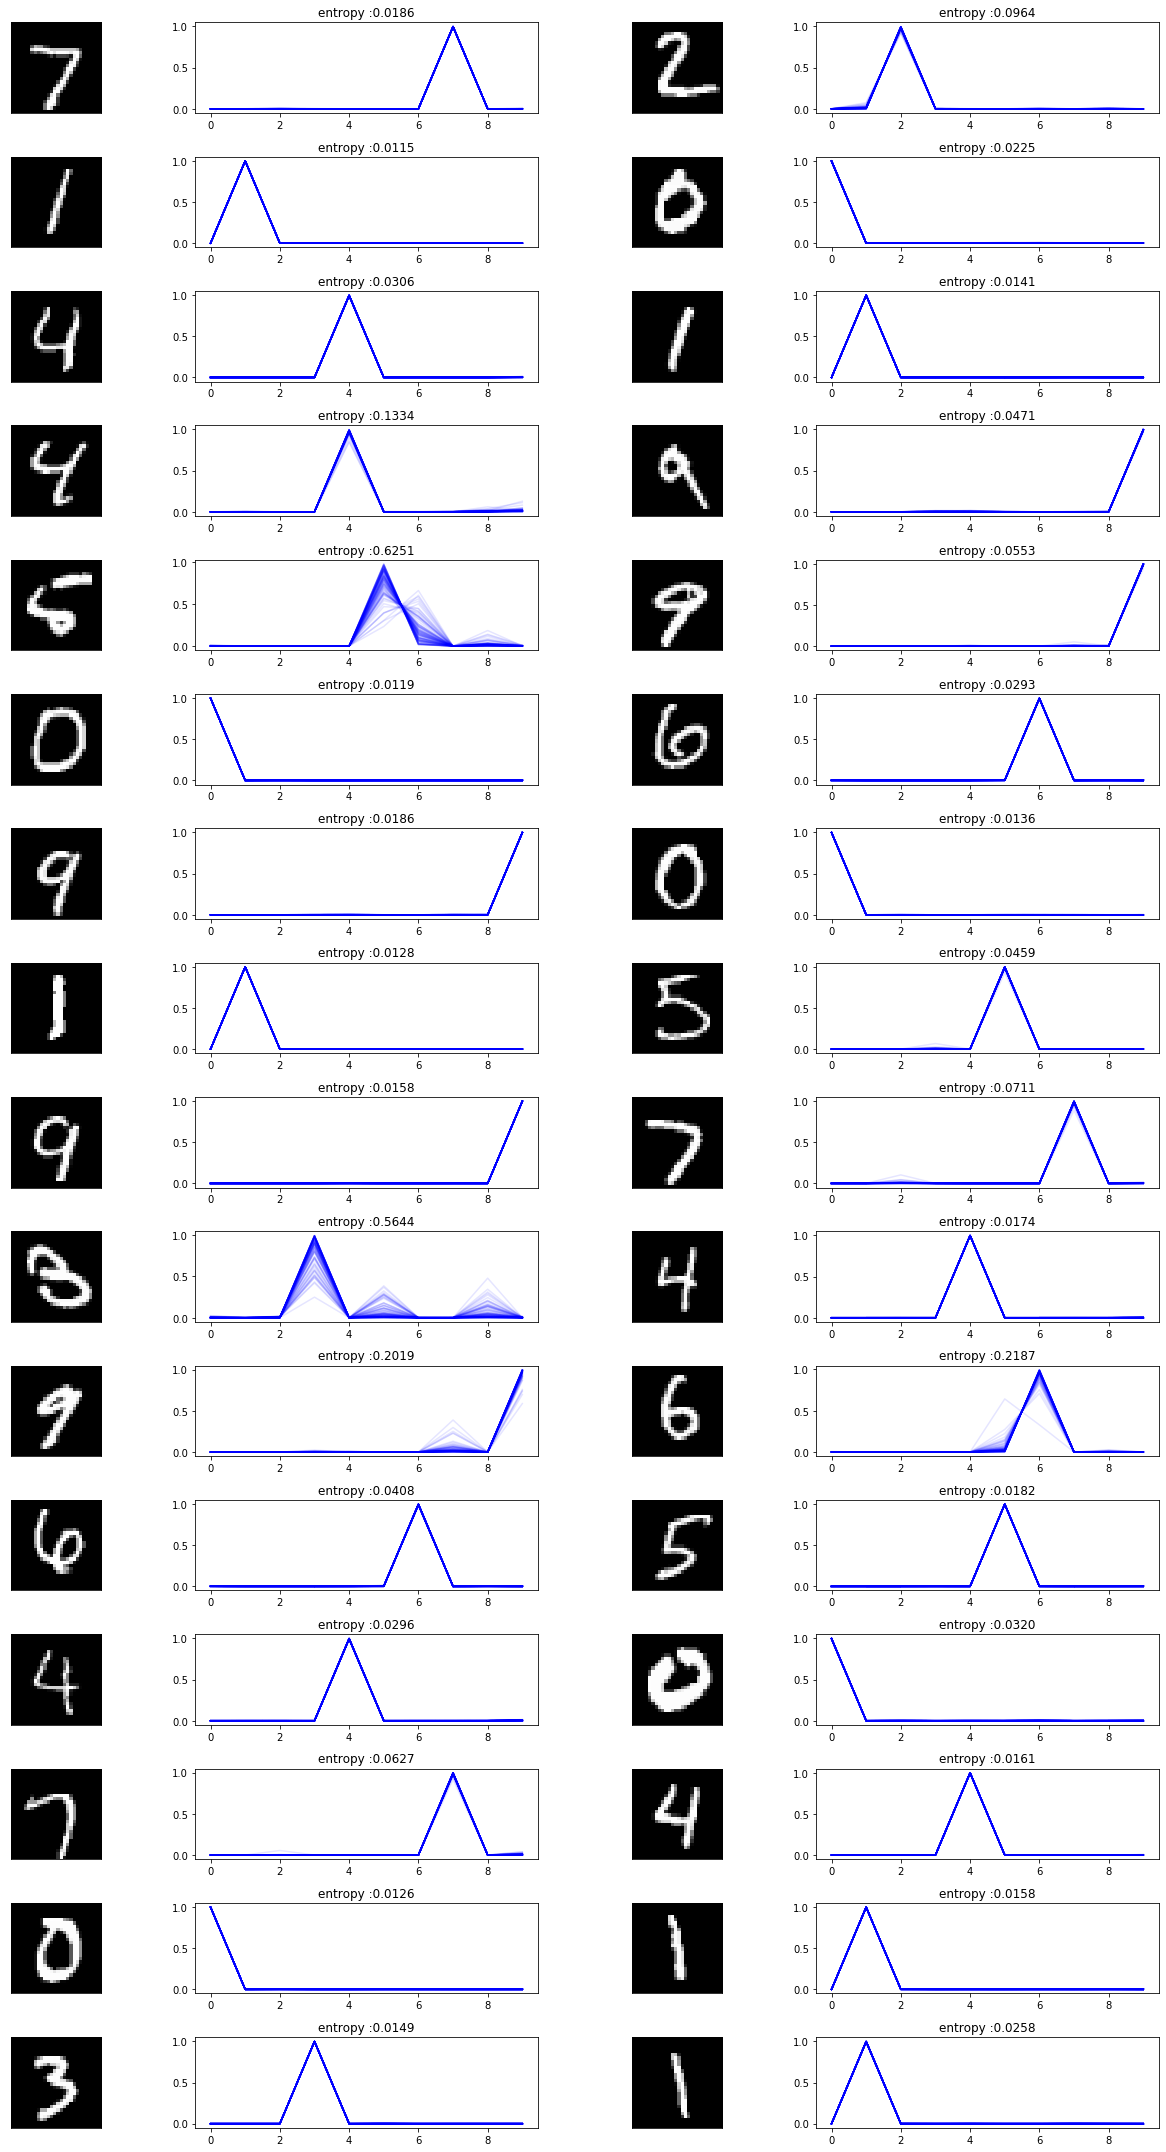

In [81]:
test_num = 100
batch = next(iter(test_loader))
x, t = batch
ys = model.inference(x.cuda(), test_num=test_num)
probs = ys.mean(dim=0)
entropy = get_entropy(probs)

_x = x.data.cpu().numpy()
_ys = ys.data.cpu().numpy()
_entropy = entropy.data.cpu().numpy()

plt.figure(figsize=[18, 30])
for i in range(32):
    plt.subplot(16, 4, i*2+1)
    plt.imshow(_x[i, 0], cmap='gist_gray')
    plt.xticks([])
    plt.yticks([])
    plt.subplot(16, 4, i*2+2)
    plt.title('entropy :' + '%0.4f' % _entropy[i])
    for j in range(test_num):
        plt.plot(_ys[j, i], color='blue', alpha=0.1)
        
plt.tight_layout()
plt.show()
